# 使用DEEPSEEK的情绪测度

DEEPSEEK出来了，咱吃屎也得赶上热乎的吧

In [ ]:
from openai import OpenAI

client = OpenAI(api_key="<DeepSeek API Key>", base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "Hello"},
    ],
    stream=False
)

print(response.choices[0].message.content)

# 日回报率测度

## 日回报率数据清洗

In [4]:
import pandas as pd

# 1. 读取数据并确保日期格式正确
df_stock = pd.read_excel("D:\mycodelife\workshop\\fake_finance\\abnormal_return\\18_22.xlsx")  # 股票收益率数据
df_events = pd.read_excel("D:\mycodelife\workshop\\fake_finance\\abnormal_return\\control_variable.xlsx")  # 事件数据

df_events['event date'] = pd.to_datetime(df_events['event date'])
df_stock['日期'] = pd.to_datetime(df_stock['日期'])

# 2. 按股票代码和日期排序（便于后续处理）
df_stock = df_stock.sort_values(['股票代码', '日期']).reset_index(drop=True)

# 3. 存放最终结果的列表，每个元素为一个字典，对应一行输出数据
result_rows = []

# 4. 遍历事件数据
for idx, event_row in df_events.iterrows():
    stock_code = event_row['股票代码']
    # 保留原始事件日期
    original_event_date = event_row['event date']
    # 初始化 event_date 为原始事件日期
    event_date = original_event_date
    
    # 对于当前事件，筛选出该股票的全部数据
    df_stock_code = df_stock[df_stock['股票代码'] == stock_code].copy()
    
    # 定义时间窗口：从事件日期前 350 天 到事件日期后 15 天
    start_date = event_date - pd.DateOffset(days=350)
    end_date = event_date + pd.DateOffset(days=15)
    
    # 在该股票数据中，筛选出日期落在该区间内的记录
    df_window = df_stock_code[(df_stock_code['日期'] >= start_date) & (df_stock_code['日期'] <= end_date)].copy()
    
    if df_window.empty:
        print(f"警告：股票 {stock_code} 在窗口内无数据，跳过。")
        continue

    # 如果事件日期不在窗口内，则选择往后最近的交易日替代
    if event_date not in df_window['日期'].values:
        # 筛选出所有大于事件日期的交易日
        df_future = df_window[df_window['日期'] > event_date]
        if not df_future.empty:
            # 由于 df_stock 已按照日期排序，df_window 也保持顺序，因此第一行就是最早的未来交易日
            new_event_date = df_future.iloc[0]['日期']
            print(f"警告：股票 {stock_code} 的事件日期 {event_date.date()} 无对应数据，使用往后最近的交易日 {new_event_date.date()} 替代。")
            event_date = new_event_date
        else:
            print(f"警告：股票 {stock_code} 的事件日期 {event_date.date()} 无对应数据且没有往后交易日，跳过。")
            continue

    # 5. 重置索引以获得连续的整数索引
    df_window = df_window.reset_index(drop=True)
    
    # 找到事件日期在窗口中的位置
    event_idx = df_window.index[df_window['日期'] == event_date][0]
    
    # 计算每一行的相对交易日偏移量：offset = 当前行索引 - event_idx
    df_window['offset'] = df_window.index - event_idx
    
    # 取出该股票的市场类型（对于该股票来说是常数）
    market_type = df_window['市场类型'].iloc[0]
    
    # 6. 构造结果字典  
    # 注意：'event date' 保留原始事件日期；新增的 '交易日0' 则记录与 offset 为 0 对应的实际交易日（即 event_date）
    event_dict = {
        '股票代码': stock_code,
        'event date': original_event_date,
        '交易日0': event_date,
        '市场类型': market_type
    }
    
    # 遍历窗口内的每一行，将 offset 对应的收益率加入字典
    for _, row in df_window.iterrows():
        offset = row['offset']  # 例如 -10, 0, 1, ...
        event_dict[offset] = row['收益率']
    
    result_rows.append(event_dict)

# 7. 合并所有事件记录为 DataFrame
df_result = pd.DataFrame(result_rows)

# 8. 对收益率列进行排序  
# 固定列为：股票代码、event date、交易日0、市场类型，其余列为数字型的 offset 列
id_cols = ['股票代码', 'event date', '交易日0', '市场类型']
offset_cols = [col for col in df_result.columns if col not in id_cols]

# 按照 offset 从小到大排序
offset_cols_sorted = sorted(offset_cols, key=lambda x: int(x))
df_result = df_result[id_cols + offset_cols_sorted]

# 9. 保存结果至 Excel 文件
df_result.to_excel('output1.xlsx', index=False)

print("处理完成，结果保存为 output1.xlsx")


警告：股票 600141 的事件日期 2015-01-02 无对应数据，使用往后最近的交易日 2015-01-06 替代。
警告：股票 156 的事件日期 2015-01-04 无对应数据，使用往后最近的交易日 2015-01-05 替代。
警告：股票 2037 的事件日期 2015-01-04 无对应数据，使用往后最近的交易日 2015-01-05 替代。
警告：股票 2453 的事件日期 2015-01-05 无对应数据且没有往后交易日，跳过。
警告：股票 600076 的事件日期 2015-01-08 无对应数据且没有往后交易日，跳过。
警告：股票 600850 的事件日期 2015-01-11 无对应数据，使用往后最近的交易日 2015-01-12 替代。
警告：股票 662 的事件日期 2015-01-26 无对应数据，使用往后最近的交易日 2015-02-02 替代。
警告：股票 600487 的事件日期 2015-02-01 无对应数据，使用往后最近的交易日 2015-02-02 替代。
警告：股票 977 的事件日期 2015-02-05 无对应数据，使用往后最近的交易日 2015-02-06 替代。
警告：股票 1696 的事件日期 2015-03-12 无对应数据，使用往后最近的交易日 2015-03-13 替代。
警告：股票 300388 的事件日期 2015-04-11 无对应数据，使用往后最近的交易日 2015-04-13 替代。
警告：股票 2241 的事件日期 2015-04-20 无对应数据，使用往后最近的交易日 2015-04-24 替代。
警告：股票 927 的事件日期 2015-05-05 无对应数据，使用往后最近的交易日 2015-05-08 替代。
警告：股票 2174 的事件日期 2015-05-10 无对应数据，使用往后最近的交易日 2015-05-11 替代。
警告：股票 2310 的事件日期 2015-06-19 无对应数据且没有往后交易日，跳过。
警告：股票 2036 的事件日期 2015-06-21 无对应数据，使用往后最近的交易日 2015-06-23 替代。
警告：股票 300197 的事件日期 2015-06-26 无对应数据且没有往后交易日，跳过。
警告：股票 715 的事件日期 2015-07-07 无

In [6]:
import pandas as pd
import numpy as np

# -------------------------------
# 1. 读取数据
# -------------------------------
df_A = pd.read_excel("output1.xlsx")
df_market = pd.read_excel("D:\mycodelife\workshop\\fake_finance\\abnormal_return\market.xlsx")

# 转换日期格式
df_A['event date'] = pd.to_datetime(df_A['event date'], errors='coerce')
df_market['日期'] = pd.to_datetime(df_market['日期'], errors='coerce')

# -------------------------------
# 2. 准备市场数据的交易日历和查找字典
# -------------------------------
market_types = df_market['市场类型'].unique()
market_calendars = {}   # 市场类型 -> 排序后的交易日 numpy 数组
for mkt in market_types:
    trading_dates = df_market.loc[df_market['市场类型'] == mkt, '日期'].sort_values().unique()
    market_calendars[mkt] = trading_dates

market_lookup = {}
for row in df_market.itertuples(index=False):
    key = (row.市场类型, row.日期)
    market_lookup[key] = row.市场收益率

# -------------------------------
# 3. 确定 A 中的偏移量列
# -------------------------------
# 注意：这里假定 A 中除 '股票代码', 'event date', '市场类型', '交易日0' 外的其余列均为偏移量列
id_cols = ['股票代码', 'event date', '市场类型', '交易日0']
offset_cols = [col for col in df_A.columns if col not in id_cols]
offsets = [int(col) for col in offset_cols]

# -------------------------------
# 4. 定义函数：根据每行 A 的相对交易日（交易日0）计算各偏移量对应的市场收益率
# -------------------------------
def compute_market_returns(row):
    # 使用相对交易日 '交易日0' 作为基准，而非事件日期
    relative_date = row['交易日0']
    market_type = row['市场类型']
    
    # 获取对应市场的交易日历
    trading_dates = market_calendars.get(market_type)
    if trading_dates is None or len(trading_dates) == 0:
        for off in offsets:
            row[f'market_{off}'] = np.nan
        return row
    
    # 将 relative_date 转换为 numpy.datetime64 类型
    relative_date_np = np.datetime64(relative_date)
    
    # 计算每个交易日与 relative_date 的差值，确定基准位置
    diffs = np.abs(trading_dates - relative_date_np)
    baseline_index = int(np.argmin(diffs))
    
    # 对于每个偏移量，计算目标交易日索引及对应的市场收益率
    for off in offsets:
        target_index = baseline_index + off
        # 若目标索引超出交易日范围，则赋值为 NaN
        if target_index < 0 or target_index >= len(trading_dates):
            row[f'market_{off}'] = np.nan
        else:
            target_date = trading_dates[target_index]
            # 将 target_date 转换为 pandas Timestamp 后再查找
            target_date_ts = pd.Timestamp(target_date)
            market_ret = market_lookup.get((market_type, target_date_ts), np.nan)
            row[f'market_{off}'] = market_ret
    return row

# -------------------------------
# 5. 对 A 的每一行计算各偏移量对应的市场收益率
# -------------------------------
df_A = df_A.apply(compute_market_returns, axis=1)

# -------------------------------
# 6. 保存结果
# -------------------------------
df_A.to_excel('A_with_market_returns.xlsx', index=False)
print("处理完成，结果保存为 A_with_market_returns.xlsx")


处理完成，结果保存为 A_with_market_returns.xlsx


## 异常收益率回归

In [7]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. 读取 Excel 文件
# 请将文件路径替换为实际的 Excel 文件路径
file_path = "D:\mycodelife\workshop\\fake_finance\\faker_news\A_with_market_returns.xlsx"
df = pd.read_excel(file_path)

# ---------------------------
# 2. 确定固定列和有效的个股收益率列（对应时间点）
fixed_cols = ['股票代码', 'event date', '交易日0', '市场类型']

# candidate_cols 为除固定列和市场收益率列之外的所有列
# 注意：将列名转换为字符串再判断是否以 'market_' 开头
candidate_cols = [col for col in df.columns if col not in fixed_cols and not str(col).startswith('market_')]

# 从 candidate_cols 中筛选出时间 t 满足 t < -5 的列，保存为整数类型
valid_t = []
for col in candidate_cols:
    try:
        t_val = int(col)
        if t_val < -5:
            valid_t.append(t_val)
    except ValueError:
        # 如果不能转换为整数，则跳过该列
        continue

# 按照时间顺序排序（从最早到最新）
valid_t.sort()

# ---------------------------
# 3. 对每一行进行回归计算
def compute_regression(row):
    xs = []  # 市场收益率序列
    ys = []  # 个股收益率序列
    
    # 遍历所有符合条件的时间点
    for t in valid_t:
        market_col = 'market_' + str(t)  # 市场收益率列名
        
        # 检查两个列是否在当前行的索引中
        if t not in row.index or market_col not in row.index:
            continue
        
        y_val = row[t]
        x_val = row[market_col]
        
        # 如果任一值缺失，则跳过该时间点
        if pd.isna(y_val) or pd.isna(x_val):
            continue
        
        xs.append(x_val)
        ys.append(y_val)
    
    # 如果没有有效数据对，则返回缺失值
    if len(xs) == 0:
        return pd.Series({'alpha': np.nan, 'beta': np.nan})
    
    xs = np.array(xs)
    ys = np.array(ys)
    
    # 计算均值
    mean_x = np.mean(xs)
    mean_y = np.mean(ys)
    
    # 计算回归系数 beta 和截距 alpha
    numerator = np.sum((xs - mean_x) * (ys - mean_y))
    denominator = np.sum((xs - mean_x) ** 2)
    
    if denominator == 0:
        beta = np.nan
        alpha = np.nan
    else:
        beta = numerator / denominator
        alpha = mean_y - beta * mean_x
    
    return pd.Series({'alpha': alpha, 'beta': beta})

# 对每一行应用回归计算
results = df.apply(compute_regression, axis=1)

# 将回归结果合并到原始 DataFrame 中
df = pd.concat([df, results], axis=1)

# ---------------------------
# 4. 保存结果至新的 Excel 文件
output_file = 'output_with_alpha_beta.xlsx'
df.to_excel(output_file, index=False)

print("回归计算完成，结果已保存至:", output_file)

回归计算完成，结果已保存至: output_with_alpha_beta.xlsx


## 计算异常收益率

In [8]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. 读取包含回归结果（alpha和beta）的 Excel 文件
file_path = 'output_with_alpha_beta.xlsx'  # 请替换为实际文件路径
df = pd.read_excel(file_path)

# ---------------------------
# 2. 定义预测时间区间：-10 到 10
time_points = list(range(-10, 11))

# ---------------------------
# 3. 定义函数：对每一行计算各时点异常收益率
def compute_abnormal_returns(row):
    # 获取该行回归系数 alpha 和 beta
    alpha = row['alpha']
    beta = row['beta']
    
    # 建立存放异常收益率的字典
    ar_dict = {}
    
    for t in time_points:
        # 市场收益率列名称
        market_col = 'market_' + str(t)
        
        # 判断个股收益率所在的列名称，可能存为整数或字符串
        if t in row.index:
            actual = row[t]
        elif str(t) in row.index:
            actual = row[str(t)]
        else:
            # 如果找不到对应个股收益率列，设为缺失值
            actual = np.nan

        # 检查市场收益率列是否存在
        if market_col in row.index:
            market = row[market_col]
        else:
            market = np.nan

        # 若任一数据缺失，则异常收益率为 NaN
        if pd.isna(actual) or pd.isna(market) or pd.isna(alpha) or pd.isna(beta):
            ar = np.nan
        else:
            # 利用回归模型预测个股收益率：
            # 预测值：predicted = alpha + beta * market
            predicted = alpha + beta * market
            # 异常收益率：实际收益率减去预测收益率
            ar = actual - predicted
        
        # 保存异常收益率，列名形如 AR_-10, AR_-9, ..., AR_10
        ar_dict['AR_' + str(t)] = ar

    return pd.Series(ar_dict)

# ---------------------------
# 4. 对每一行计算异常收益率（AR）
ar_results = df.apply(compute_abnormal_returns, axis=1)

# ---------------------------
# 5. 构建输出 DataFrame
# 固定信息列：股票代码、event date、交易日0（0交易日）、市场类型，以及回归系数 alpha、beta
fixed_cols = ['股票代码', 'event date', '交易日0', '市场类型', 'alpha', 'beta']
# 异常收益率列名称列表
ar_columns = ['AR_' + str(t) for t in time_points]

# 合并固定列与异常收益率列
result_df = pd.concat([df[fixed_cols], ar_results], axis=1)

# ---------------------------
# 6. 保存结果到新 Excel 文件
output_file = 'abnormal_returns.xlsx'
result_df.to_excel(output_file, index=False)

print("异常收益率计算完成，结果已保存至:", output_file)


异常收益率计算完成，结果已保存至: abnormal_returns.xlsx


## 合并数据表

In [9]:
import pandas as pd

# 1. 读取两个 Excel 文件
# 请根据实际情况替换文件路径
df1 = pd.read_excel('abnormal_returns.xlsx')
df2 = pd.read_excel("D:\mycodelife\workshop\\fake_finance\\abnormal_return\\fin_control_vars.xlsx")

# 2. 如果需要，统一 event date 的数据类型（例如转换为日期类型）
df1['event date'] = pd.to_datetime(df1['event date'])
df2['event date'] = pd.to_datetime(df2['event date'])

# 3. 根据共同键（股票代码, event date）进行合并
# 这里采用 inner join：只保留两个表中都存在的匹配行
merged_df = pd.merge(df1, df2, on=['股票代码', 'event date'], how='left')

# 4. 将合并后的结果保存到新的 Excel 文件中
merged_df.to_excel('merged_output.xlsx', index=False)

print("两个 Excel 文件已成功根据 (股票代码, event date) 合并，并保存到 merged_output.xlsx")


两个 Excel 文件已成功根据 (股票代码, event date) 合并，并保存到 merged_output.xlsx


In [10]:
import pandas as pd

# 1. 读取两个 Excel 文件
# 请根据实际情况替换文件路径
df1 = pd.read_excel('merged_output.xlsx')
df2 = pd.read_excel("truth.xlsx")

# 2. 如果需要，统一 event date 的数据类型（例如转换为日期类型）
df1['event date'] = pd.to_datetime(df1['event date'])
df2['event date'] = pd.to_datetime(df2['event date'])

# 3. 根据共同键（股票代码, event date）进行合并
# 这里采用 inner join：只保留两个表中都存在的匹配行
merged_df = pd.merge(df1, df2, on=['股票代码', 'event date'], how='left')

# 4. 将合并后的结果保存到新的 Excel 文件中
merged_df.to_excel('data_for_did_without_sential.xlsx', index=False)

print("两个 Excel 文件已成功根据 (股票代码, event date) 合并，并保存到 merged_output.xlsx")


两个 Excel 文件已成功根据 (股票代码, event date) 合并，并保存到 merged_output.xlsx


# DID

### 数据读取与处理

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

# 1. 读取数据（请将 'your_data.csv' 替换为你的数据文件路径）
df = pd.read_excel('data_for_did_without_sential.xlsx')

# 2. 提取所有以 "AR_" 开头的列作为事件窗口的异常收益
ar_cols = [col for col in df.columns if col.startswith('AR_')]

# 3. 确定 id_vars：保留除异常收益以外的列（假设已删去股票代码、event date、交易日0、市场类型等变量）
id_vars = [col for col in df.columns if col not in ar_cols]

# 4. 将数据从宽格式转换为长格式，生成新列 "time"（事件时点）和 "AR"（异常收益）
df_long = pd.melt(df, id_vars=id_vars, value_vars=ar_cols, var_name='time', value_name='AR')

# 5. 将 “time” 列转换为数值型变量
#    假设 time 格式为 "AR_-10", "AR_0", "AR_10" 等
df_long['time_num'] = df_long['time'].str.replace('AR_', '').astype(int)

# 6. 对 AR 列进行均值插补，处理缺失值
imputer = SimpleImputer(strategy='mean')
df_long[['AR']] = imputer.fit_transform(df_long[['AR']])

# 7. 构造处理后时点的虚拟变量：当 time_num >= 0 时取 1，否则取 0
df_long['Post'] = (df_long['time_num'] >= 0).astype(int)

# 8. 构造 DID 交互项：did = truth * Post
#    这里假设 truth 已经为 0/1 变量（1 表示受处理组，0 表示对照组）
df_long['did'] = df_long['truth'] * df_long['Post']

# 9. 针对含有特殊字符的变量进行重命名（方便后续建模）
rename_dict = {
    '年报资产报酬率（%）': 'AssetReturn',
    '年报资产报酬率TTM（%）': 'AssetReturn_TTM',
    '年报营业利润率（%）': 'OperatingProfitMargin',
    '流动比率（%）': 'CurrentRatio',
    '速动比率（%）': 'QuickRatio',
    '净资产负债率（%）': 'NetDebtRatio',
    '年报总资产周转率（次）': 'AssetTurnover',
    '年报总资产周转率TTM（次）': 'AssetTurnover_TTM',
    '资产负债率（%）': 'DebtRatio',
    '年报非流动资产/总资产（%）': 'NonCurrentAsset_Ratio'
}
df_long.rename(columns=rename_dict, inplace=True)

# 10. 指定其他控制变量（使用重命名后的变量名）
control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]


## 加控制变量

In [4]:

# 11. 构造回归公式
#     模型为：AR ~ truth + Post + did + 控制变量
formula = 'AR ~ truth + Post + did'
if control_vars:
    formula += ' + ' + ' + '.join(control_vars)

print("回归公式：", formula)

# 12. 使用 OLS 估计 DID 模型（不采用分组聚类稳健标准误）
model = smf.ols(formula, data=df_long).fit()

# 13. 输出回归结果
print(model.summary())

回归公式： AR ~ truth + Post + did + AssetReturn + AssetReturn_TTM + OperatingProfitMargin + CurrentRatio + QuickRatio + NetDebtRatio + AssetTurnover + AssetTurnover_TTM + DebtRatio + NonCurrentAsset_Ratio
                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     15.41
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           1.85e-35
Time:                        16:59:38   Log-Likelihood:                 37264.
No. Observations:               19593   AIC:                        -7.450e+04
Df Residuals:                   19579   BIC:                        -7.439e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
         

## 不加控制变量

In [5]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

# 1. 读取数据（请将 'your_data.csv' 替换为你的数据文件路径）
df = pd.read_excel('data_for_did_without_sential.xlsx')

# 2. 提取所有以 "AR_" 开头的列作为事件窗口的异常收益
ar_cols = [col for col in df.columns if col.startswith('AR_')]

# 3. 确定 id_vars：保留除异常收益以外的列（假设已删去股票代码、event date、交易日0、市场类型等变量）
id_vars = [col for col in df.columns if col not in ar_cols]

# 4. 将数据从宽格式转换为长格式，生成新列 "time"（事件时点）和 "AR"（异常收益）
df_long = pd.melt(df, id_vars=id_vars, value_vars=ar_cols, var_name='time', value_name='AR')

# 5. 将 “time” 列转换为数值型变量
#    假设 time 格式为 "AR_-10", "AR_0", "AR_10" 等
df_long['time_num'] = df_long['time'].str.replace('AR_', '').astype(int)

# 6. 对 AR 列进行均值插补，处理缺失值
imputer = SimpleImputer(strategy='mean')
df_long[['AR']] = imputer.fit_transform(df_long[['AR']])

# 7. 构造处理后时点的虚拟变量：当 time_num >= 0 时取 1，否则取 0
df_long['Post'] = (df_long['time_num'] >= 0).astype(int)

# 8. 构造 DID 交互项：did = truth * Post
#    这里假设 truth 已经为 0/1 变量（1 表示受处理组，0 表示对照组）
df_long['did'] = df_long['truth'] * df_long['Post']

# 9. 针对含有特殊字符的变量进行重命名（方便后续建模）
rename_dict = {
    '年报资产报酬率（%）': 'AssetReturn',
    '年报资产报酬率TTM（%）': 'AssetReturn_TTM',
    '年报营业利润率（%）': 'OperatingProfitMargin',
    '流动比率（%）': 'CurrentRatio',
    '速动比率（%）': 'QuickRatio',
    '净资产负债率（%）': 'NetDebtRatio',
    '年报总资产周转率（次）': 'AssetTurnover',
    '年报总资产周转率TTM（次）': 'AssetTurnover_TTM',
    '资产负债率（%）': 'DebtRatio',
    '年报非流动资产/总资产（%）': 'NonCurrentAsset_Ratio'
}
df_long.rename(columns=rename_dict, inplace=True)

# 10. 指定其他控制变量（使用重命名后的变量名）
control_vars = []

# 11. 构造回归公式
#     模型为：AR ~ truth + Post + did + 控制变量
formula = 'AR ~ truth + Post + did'
if control_vars:
    formula += ' + ' + ' + '.join(control_vars)

print("回归公式：", formula)

# 12. 使用 OLS 估计 DID 模型（不采用分组聚类稳健标准误）
model = smf.ols(formula, data=df_long).fit()

# 13. 输出回归结果
print(model.summary())

回归公式： AR ~ truth + Post + did
                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.784
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           0.000144
Time:                        16:52:14   Log-Likelihood:                 37175.
No. Observations:               19593   AIC:                        -7.434e+04
Df Residuals:                   19589   BIC:                        -7.431e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027 

## 事前平行趋势

                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.833
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           3.35e-27
Time:                        19:47:09   Log-Likelihood:                 37287.
No. Observations:               19593   AIC:                        -7.447e+04
Df Residuals:                   19541   BIC:                        -7.406e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

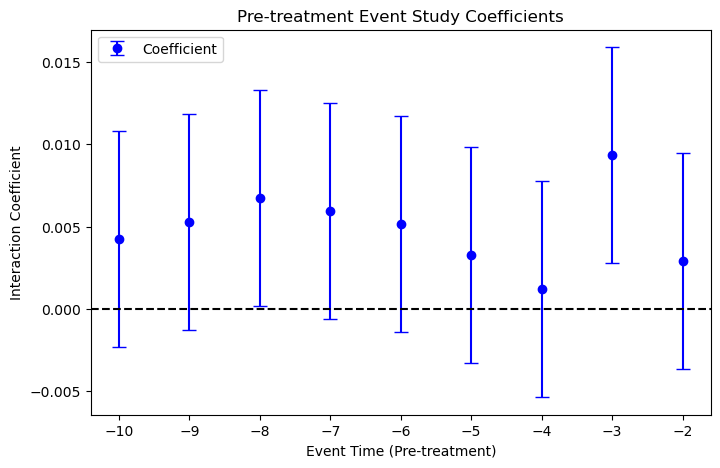

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 假设 df_long 已经准备好，且包含以下变量：
# AR, truth, time_num, 以及重命名后的控制变量（例如 alpha, beta, AssetReturn, 等）

# 直接在原数据 df_long 上修改预处理期（例如 t=-4 和 t=-2）对应的 AR 变量
"""
for t in [-5, -4 ,-2]:
    for grp in [0, 1]:
        mask = (df_long['time_num'] == t) & (df_long['truth'] == grp)
        mean_val = df_long.loc[mask, 'AR'].mean()
        # 直接修改原数据：减去组内均值
        df_long.loc[mask, 'AR'] = df_long.loc[mask, 'AR'] - mean_val

"""

# 定义控制变量（请根据实际情况修改）
control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]

# (1) 构造事件研究模型
# 利用 Patsy 的 C() 函数构造 time_num 的分类变量，并设定参考组为 -1
formula_event = 'AR ~ ' + ' + '.join(control_vars) + ' + truth * C(time_num, Treatment(reference=-1))'

# 估计模型
model_event = smf.ols(formula_event, data=df_long).fit()
print(model_event.summary())

# (2) 提取交互项系数，即不同相对时点下处理组与对照组的差异变化
# Patsy 给出的变量名称一般形如: "truth:C(time_num, Treatment(reference=-1))[T.-10]"
coefs = model_event.params.filter(like='truth:C(time_num, Treatment(reference=-1))')
conf_int = model_event.conf_int().loc[coefs.index]

# 将系数提取为列表，并只关注处理前的时点（time_num < 0），同时排除基准期 -1
pre_event = []
estimates = []
lower_ci = []
upper_ci = []

# 这里使用 .items() 替代 .iteritems()
for idx, coef in coefs.items():
    # 变量名的格式类似 "truth:C(time_num, Treatment(reference=-1))[T.-10]"
    # 提取括号内的数字部分
    try:
        event_time = idx.split('[')[-1].replace('T.', '').replace(']', '')
        event_time = int(event_time)
        if event_time < 0 and event_time != -1:  # 只关注基准期前的时点（排除参考期 -1）
            pre_event.append(event_time)
            estimates.append(coef)
            lower_ci.append(conf_int.loc[idx, 0])
            upper_ci.append(conf_int.loc[idx, 1])
    except Exception as e:
        print(f"Error processing {idx}: {e}")
        continue

# 排序（按照相对时点升序排列）
order = np.argsort(pre_event)
pre_event = np.array(pre_event)[order]
estimates = np.array(estimates)[order]
lower_ci = np.array(lower_ci)[order]
upper_ci = np.array(upper_ci)[order]

# (3) 绘制预处理期各时点的交互项系数及置信区间
plt.figure(figsize=(8, 5))
plt.errorbar(pre_event, estimates,
             yerr=[estimates - lower_ci, upper_ci - estimates],
             fmt='o', capsize=5, color='b', label='Coefficient')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Event Time (Pre-treatment)')
plt.ylabel('Interaction Coefficient')
plt.title('Pre-treatment Event Study Coefficients')
plt.legend()
plt.show()


### 正在尝试剔除异常值

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 假设 df_long 已经准备好，且包含变量：AR, truth, time_num 以及控制变量


control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]

# 构造事件研究模型公式
formula_event = 'AR ~ ' + ' + '.join(control_vars) + ' + truth * C(time_num, Treatment(reference=-1))'

# ----------------------------
# (1) 原始OLS回归
model_initial = smf.ols(formula_event, data=df_long).fit()
# print("原始OLS回归结果：")
# print(model_initial.summary())

# ----------------------------
# (2) 剔除异常值：计算标准化残差并过滤
std_resid = model_initial.resid / model_initial.resid.std()
# 仅保留 |r_i| < 3 的观测
df_filtered = df_long[np.abs(std_resid) < 3]

# 使用过滤后的数据重新估计模型
model_filtered = smf.ols(formula_event, data=df_filtered).fit()
print("剔除异常值后的OLS回归结果：")
print(model_filtered.summary())

# 如果后续的事件研究图形等操作依赖于回归结果，可以对 model_filtered 进行处理
# 例如提取交互项系数等（代码同原始示例，可相应替换 model_initial 为 model_filtered）


剔除异常值后的OLS回归结果：
                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.057
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           3.54e-29
Time:                        16:58:56   Log-Likelihood:                 40458.
No. Observations:               19280   AIC:                        -8.081e+04
Df Residuals:                   19228   BIC:                        -8.040e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### 去均值

In [6]:
# 复制数据框以避免直接修改原始数据
df_demeaned = df_long.copy()
formula_event = 'AR ~ ' + ' + '.join(control_vars) + ' + truth * C(time_num, Treatment(reference=-1))'
# 对连续变量（因变量和控制变量）进行去均值处理
vars_to_demean = ['AR'] + control_vars
for var in vars_to_demean:
    df_demeaned[var] = df_demeaned[var] - df_demeaned[var].mean()

# 使用去均值后的数据进行回归
model_demeaned = smf.ols(formula_event, data=df_demeaned).fit()
print("去均值处理后的OLS回归结果：")
print(model_demeaned.summary())


去均值处理后的OLS回归结果：
                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.833
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           3.35e-27
Time:                        19:54:26   Log-Likelihood:                 37287.
No. Observations:               19593   AIC:                        -7.447e+04
Df Residuals:                   19541   BIC:                        -7.406e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### 倾向匹配得分

         Current function value: 0.666000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  truth   No. Observations:                19593
Model:                          Logit   Df Residuals:                    19582
Method:                           MLE   Df Model:                           10
Date:                Sat, 15 Feb 2025   Pseudo R-squ.:                 0.03874
Time:                        23:24:00   Log-Likelihood:                -13049.
converged:                      False   LL-Null:                       -13575.
Covariance Type:            nonrobust   LLR p-value:                1.239e-219
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -69.4668   5.21e+04     -0.001      0.999   -1.02e+05    1.02e+05
AssetReturn               0.1723

c:\ProgramData\Anaconda3\envs\dirty_test\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


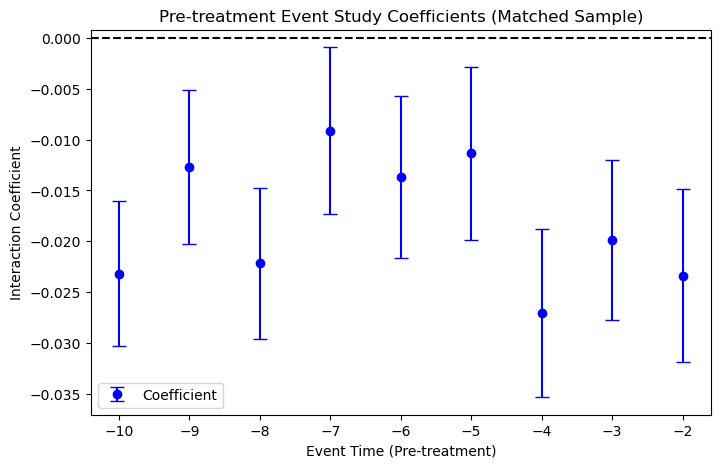

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 假设 df_long 包含变量：AR, truth, time_num 以及控制变量
control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]

# 构造事件研究模型公式（这里参考期仍为 -1）
formula_event = 'AR ~ ' + ' + '.join(control_vars) + ' + truth * C(time_num, Treatment(reference=-1))'

# ----------------------------
# (1) 估计倾向得分
# 使用Logit模型估计倾向得分，truth为二元处理变量
ps_formula = 'truth ~ ' + ' + '.join(control_vars)
ps_model = smf.logit(ps_formula, data=df_long).fit()
df_long['pscore'] = ps_model.predict(df_long)
print(ps_model.summary())

# ----------------------------
# (2) 根据倾向得分进行匹配（以最近邻匹配为例）
# 分离处理组和对照组
treated = df_long[df_long['truth'] == 1].copy()
control = df_long[df_long['truth'] == 0].copy()

# 使用sklearn的NearestNeighbors在对照组中寻找最近邻匹配
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['pscore']])
distances, indices = nn.kneighbors(treated[['pscore']])
# 注意：indices 是对照组的索引位置
matched_control_indices = control.index[indices.flatten()]

# 构造匹配样本
df_matched = pd.concat([treated, control.loc[matched_control_indices]], axis=0)

# 可选：检验匹配后协变量平衡
# 例如比较处理组和匹配对照组在各协变量上的均值

# ----------------------------
# (3) 在匹配样本上进行事件研究回归
model_matched = smf.ols(formula_event, data=df_matched).fit()
print("匹配样本上的事件研究回归结果：")
print(model_matched.summary())

# ----------------------------
# (4) 提取交互项系数并绘制预处理期的效应（例如关注time_num<0的时点）
coefs = model_matched.params.filter(like='truth:C(time_num, Treatment(reference=-1))')
conf_int = model_matched.conf_int().loc[coefs.index]

pre_event = []
estimates = []
lower_ci = []
upper_ci = []

for idx, coef in coefs.items():
    try:
        event_time = idx.split('[')[-1].replace('T.', '').replace(']', '')
        event_time = int(event_time)
        if event_time < 0 and event_time != -1:  # 只关注基准期前的时点，排除参考期 -1
            pre_event.append(event_time)
            estimates.append(coef)
            lower_ci.append(conf_int.loc[idx, 0])
            upper_ci.append(conf_int.loc[idx, 1])
    except Exception as e:
        print(f"处理 {idx} 时出错: {e}")
        continue

order = np.argsort(pre_event)
pre_event = np.array(pre_event)[order]
estimates = np.array(estimates)[order]
lower_ci = np.array(lower_ci)[order]
upper_ci = np.array(upper_ci)[order]

plt.figure(figsize=(8, 5))
plt.errorbar(pre_event, estimates,
             yerr=[estimates - lower_ci, upper_ci - estimates],
             fmt='o', capsize=5, color='b', label='Coefficient')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Event Time (Pre-treatment)')
plt.ylabel('Interaction Coefficient')
plt.title('Pre-treatment Event Study Coefficients (Matched Sample)')
plt.legend()
plt.show()


In [4]:
# 复制匹配样本，避免直接修改原数据
df_matched_centered = df_matched.copy()

# 对预处理期 t = -4 和 t = -2 分别进行组内均值中心化
for t in [-4, -2]:
    for grp in [0, 1]:
        # 筛选出该时点且属于当前组的数据
        mask = (df_matched_centered['time_num'] == t) & (df_matched_centered['truth'] == grp)
        mean_val = df_matched_centered.loc[mask, 'AR'].mean()
        # 对 AR 进行中心化：减去组内均值
        df_matched_centered.loc[mask, 'AR'] = df_matched_centered.loc[mask, 'AR'] - mean_val
model_matched_centered = smf.ols(formula_event, data=df_matched_centered).fit()


## 平行趋势检验所有期

In [11]:
import pandas as pd
import statsmodels.formula.api as smf

# control_vars为控制变量列表，df_long为数据集
control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]

# 构造事件研究模型公式：使用 C(time_num, Treatment(reference=-1)) 生成相对期虚拟变量
formula_event = 'AR ~ ' + ' + '.join(control_vars) + ' + truth * C(time_num, Treatment(reference=-1))'

# 拟合模型（这里可使用全部数据或经过异常值剔除后的数据）
model = smf.ols(formula_event, data=df_long).fit()
print("事件研究模型回归结果：")
print(model.summary())


事件研究模型回归结果：
                            OLS Regression Results                            
Dep. Variable:                     AR   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.833
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           3.35e-27
Time:                        19:58:38   Log-Likelihood:                 37287.
No. Observations:               19593   AIC:                        -7.447e+04
Df Residuals:                   19541   BIC:                        -7.406e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## 绘图

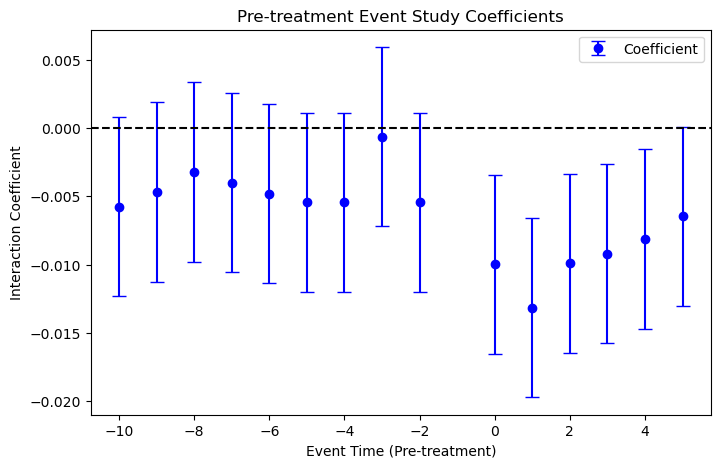

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
# (2) 提取交互项系数，即不同相对时点下处理组与对照组的差异变化
# Patsy 给出的变量名称一般形如: "truth:C(time_num, Treatment(reference=-1))[T.-10]"
def pre_treatment_old(model_filtered):
    coefs = model_filtered.params.filter(like='truth:C(time_num, Treatment(reference=-1))')
    conf_int = model_filtered.conf_int().loc[coefs.index]

    # 将系数提取为列表，并只关注处理前的时点（time_num < 0），同时排除基准期 -1
    pre_event = []
    estimates = []
    lower_ci = []
    upper_ci = []

    # 这里使用 .items() 替代 .iteritems()
    for idx, coef in coefs.items():
        # 变量名的格式类似 "truth:C(time_num, Treatment(reference=-1))[T.-10]"
        # 提取括号内的数字部分
        try:
            event_time = idx.split('[')[-1].replace('T.', '').replace(']', '')
            event_time = int(event_time)
            if event_time < 6: #and event_time != -1:  # 只关注基准期前的时点（排除参考期 -1）
                pre_event.append(event_time)
                estimates.append(coef)
                lower_ci.append(conf_int.loc[idx, 0])
                upper_ci.append(conf_int.loc[idx, 1])
        except Exception as e:
            print(f"Error processing {idx}: {e}")
            continue

    # 排序（按照相对时点升序排列）
    order = np.argsort(pre_event)
    pre_event = np.array(pre_event)[order]
    estimates = np.array(estimates)[order]
    lower_ci = np.array(lower_ci)[order]
    upper_ci = np.array(upper_ci)[order]

    # (3) 绘制预处理期各时点的交互项系数及置信区间
    plt.figure(figsize=(8, 5))
    plt.errorbar(pre_event, estimates,
                yerr=[estimates - lower_ci, upper_ci - estimates],
                fmt='o', capsize=5, color='b', label='Coefficient')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Event Time (Pre-treatment)')
    plt.ylabel('Interaction Coefficient')
    plt.title('Pre-treatment Event Study Coefficients')
    plt.legend()
    plt.show()
pre_treatment_old(model_event)

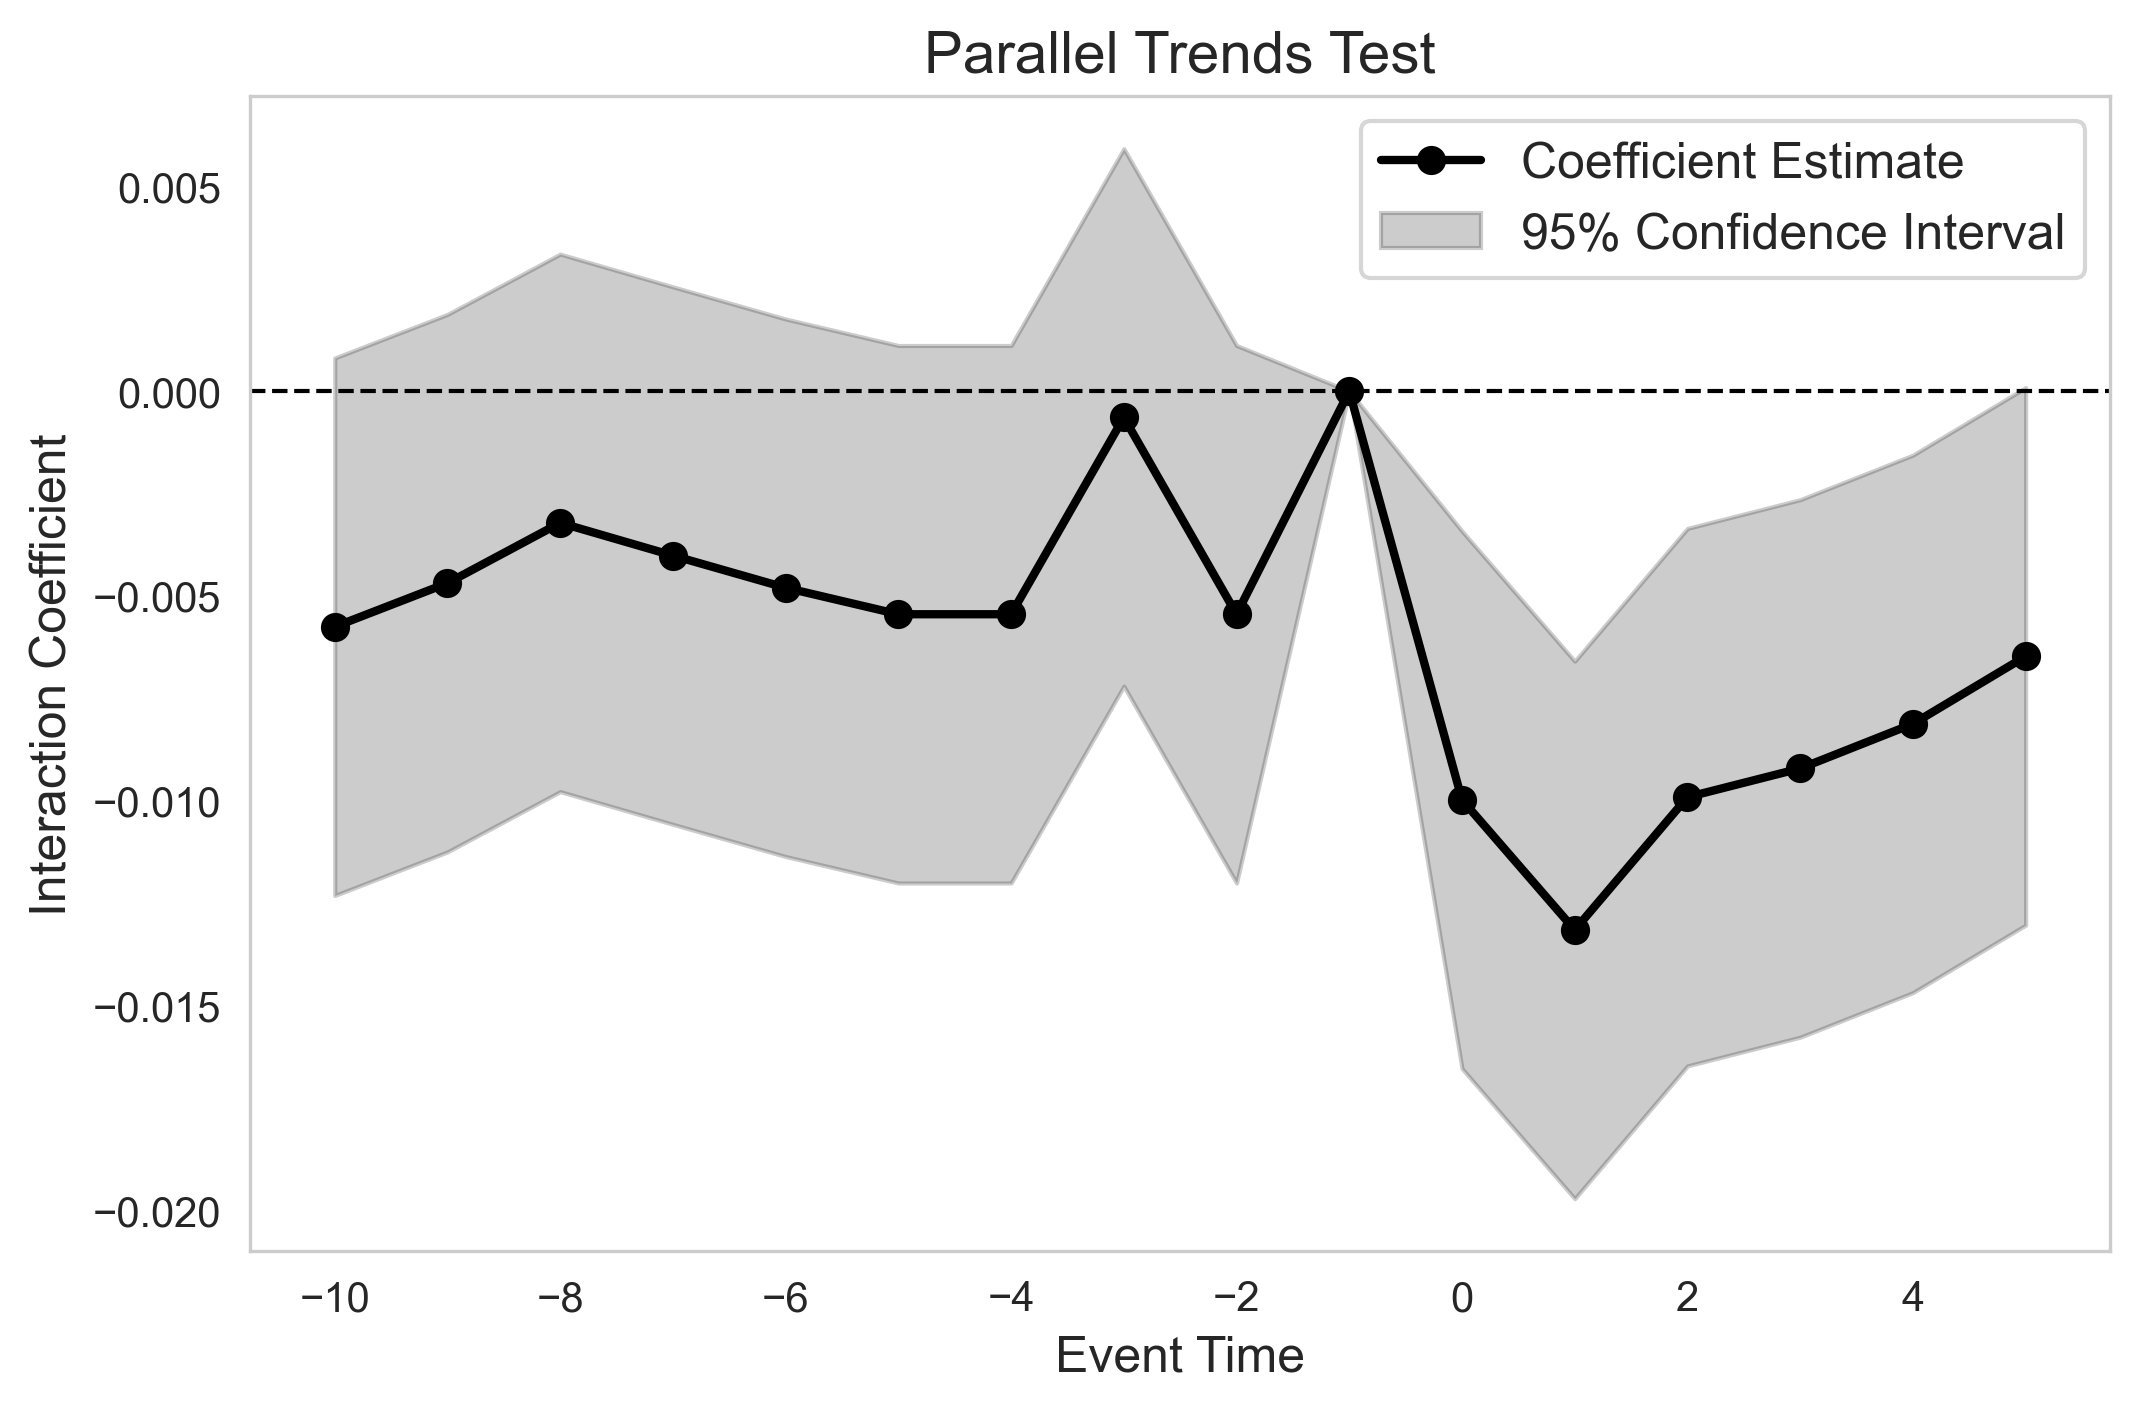

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

def plot_pre_treatment_event_study(model_filtered, save_path=None, dpi=300):
    """
    Plot the pre-treatment event study chart (including the baseline at -1) that displays the interaction coefficient
    between treatment and control groups at different event times along with their 95% confidence intervals.
    
    Parameters
    ----------
    model_filtered : statsmodels regression results object
        The fitted model that includes the interaction terms. The parameter names should follow the format:
            "truth:C(time_num, Treatment(reference=-1))[T.X]"
        where X represents the event time (e.g., -10, -5, 0, 1, etc.).
    
    save_path : str, optional
        If provided, the plot will be saved to the specified file path.
    
    dpi : int, optional
        Dots per inch (dpi) setting for the saved image (default is 300 for high resolution).
    
    Mathematical Notation
    -----------------------
    Let $\hat{\beta}(t)$ denote the estimated coefficient at event time $t$, with its 95% confidence interval $[L(t), U(t)]$. 
    The baseline event time $t=-1$ is normalized such that:
    
    $$
    \hat{\beta}(-1)=0,\quad L(-1)=U(-1)=0.
    $$
    
    The plot connects $\hat{\beta}(t)$ over time and displays the confidence intervals as a shaded area.
    """
    
    # Define the pattern for the interaction coefficients in the variable names
    coef_pattern = 'truth:C(time_num, Treatment(reference=-1))'
    
    # Filter the model's parameters and confidence intervals for those related to the event study
    coefs = model_filtered.params.filter(like=coef_pattern)
    conf_int = model_filtered.conf_int().loc[coefs.index]
    
    # Initialize lists to store event times, coefficient estimates, and confidence interval bounds
    event_times = []
    estimates = []
    lower_ci = []
    upper_ci = []
    
    # Extract event times and corresponding coefficient information from parameter names
    for idx, coef in coefs.items():
        try:
            # Expected variable name format: "truth:C(time_num, Treatment(reference=-1))[T.X]"
            event_str = idx.split('[')[-1].replace('T.', '').replace(']', '')
            event_time = int(event_str)
            
            # Select event times of interest (e.g., less than 6; adjust if needed)
            if event_time < 6:
                event_times.append(event_time)
                estimates.append(coef)
                lower_ci.append(conf_int.loc[idx, 0])
                upper_ci.append(conf_int.loc[idx, 1])
        except Exception as e:
            print(f"Error processing {idx}: {e}")
            continue
            
    # Manually add the baseline (-1) if not present; its coefficient is set to 0 with no uncertainty.
    if -1 not in event_times:
        event_times.append(-1)
        estimates.append(0.0)
        lower_ci.append(0.0)
        upper_ci.append(0.0)
    
    # Sort the event times and corresponding values in ascending order
    sorted_indices = np.argsort(event_times)
    event_times = np.array(event_times)[sorted_indices]
    estimates = np.array(estimates)[sorted_indices]
    lower_ci = np.array(lower_ci)[sorted_indices]
    upper_ci = np.array(upper_ci)[sorted_indices]
    
    # Create the plot with overall black color and enhanced clarity, specifying a higher dpi
    plt.figure(figsize=(8, 5), dpi=dpi)
    
    # Plot the coefficient estimates as a line with markers (using black for all elements)
    plt.plot(event_times, estimates, marker='o', linestyle='-', color='black', 
             linewidth=2, markersize=6, label='Coefficient Estimate')
    
    # Plot the 95% confidence interval as a shaded area (black with transparency)
    plt.fill_between(event_times, lower_ci, upper_ci, color='black', alpha=0.2, label='95% Confidence Interval')
    
    # Draw a horizontal line at zero (black dashed line)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    # Set labels and title in English
    plt.xlabel('Event Time', fontsize=12)
    plt.ylabel('Interaction Coefficient', fontsize=12)
    plt.title('Parallel Trends Assumption Test', fontsize=14)
    
    # Remove grid lines to eliminate the default gray dashed lines
    plt.grid(False)
    
    # Add legend with increased font size for clarity
    plt.legend(fontsize=12)
    
    # Enhance tick label clarity
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Save the figure as a high resolution image if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

# Example usage:
# Assuming the fitted model object is model_event, call:
plot_pre_treatment_event_study(model_event, save_path='high_res_event_study.png', dpi=300)


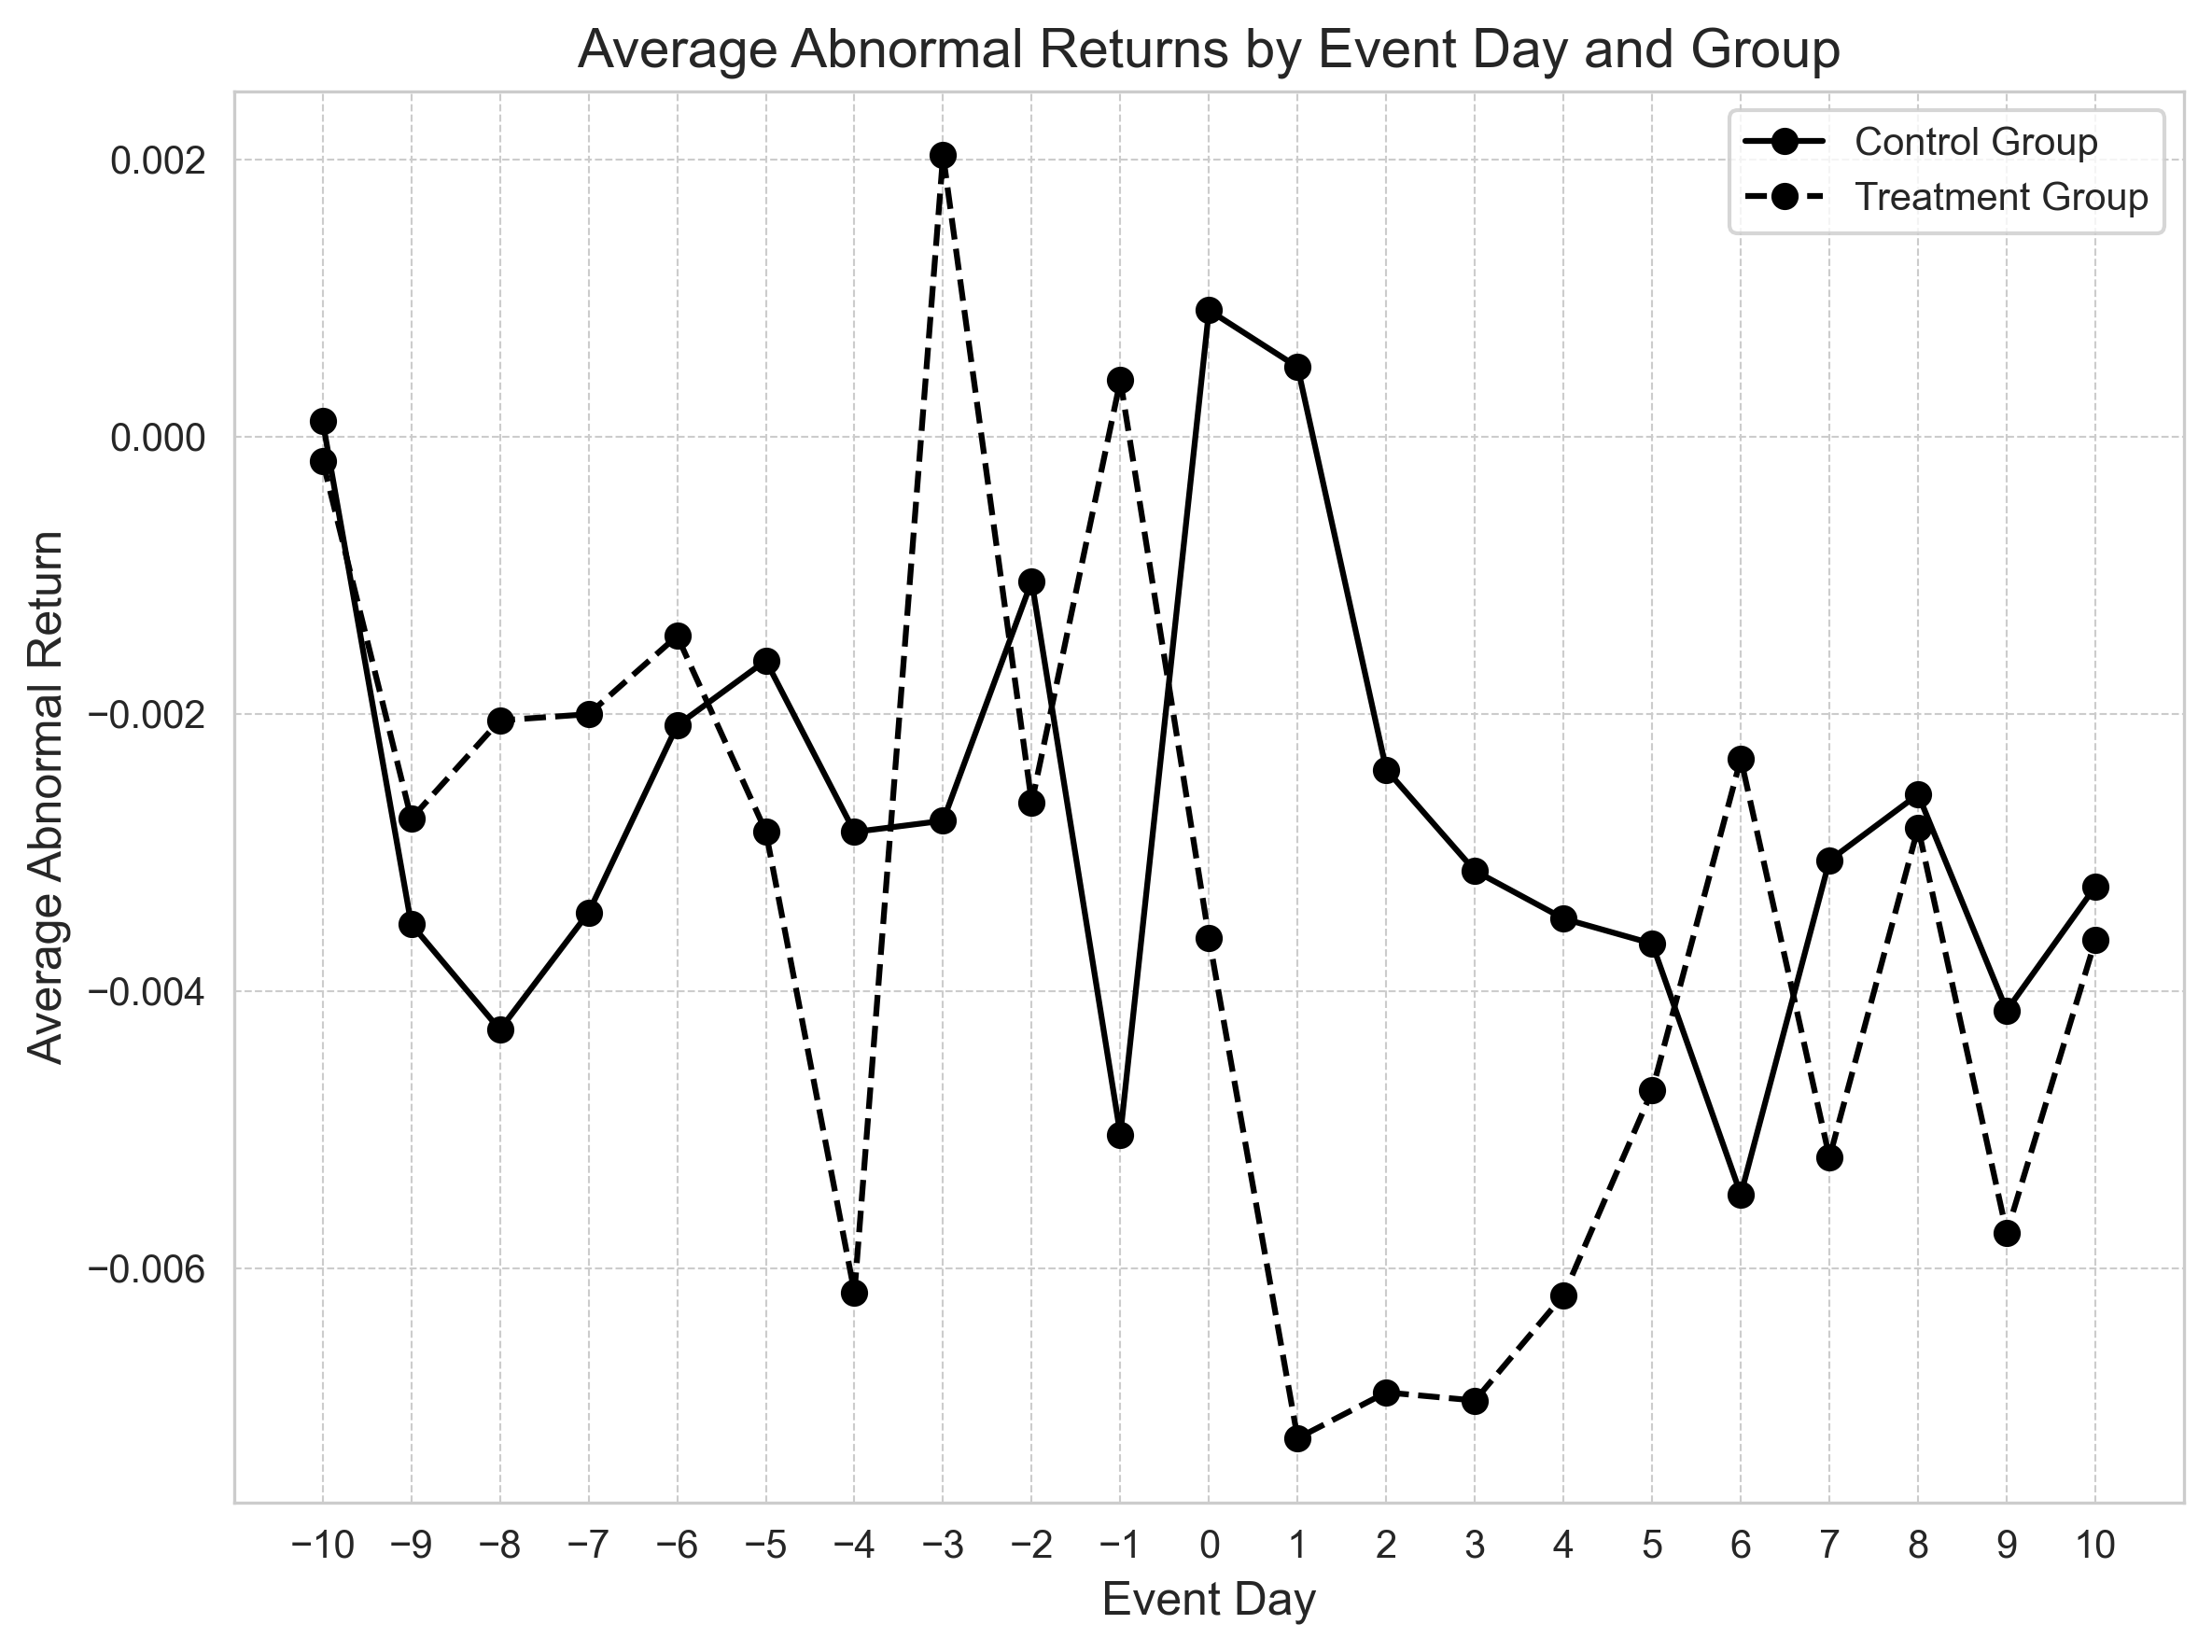

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 为你的 DataFrame，其中包含以下列：
# AR_-10, AR_-9, ..., AR_-1, AR_0, AR_1, ..., AR_10，以及 truth（0 表示对照组，1 表示处理组）

# 1. 提取所有事件窗异常收益的列（列名均以 "AR_" 开头）
ar_cols = [col for col in df.columns if col.startswith('AR_')]

# 2. 提取事件天数（例如 -10, -9, ..., 0, 1, ...）并按顺序排序
time_points = [int(col.replace('AR_', '')) for col in ar_cols]
time_points, ar_cols = zip(*sorted(zip(time_points, ar_cols)))

# 3. 按 truth 分组，计算各事件天数下的平均异常收益
group_means = df.groupby('truth')[list(ar_cols)].mean().T

# 4. 绘制折线图：采用黑色线条，不同线型区分组别，图形分辨率为300 dpi
plt.figure(figsize=(8, 6), dpi=300)

# 绘制对照组（truth==0）：实线
plt.plot(time_points, group_means[0], marker='o', linestyle='-', color='black', label='Control Group')
# 绘制处理组（truth==1）：虚线
plt.plot(time_points, group_means[1], marker='o', linestyle='--', color='black', label='Treatment Group')

# 5. 设置英文图注、轴标签、标题及网格（符合学术规范）
plt.xlabel('Event Day', fontsize=12)
plt.ylabel('Average Abnormal Return', fontsize=12)
plt.title('Average Abnormal Returns by Event Day and Group', fontsize=14)

# 设置横坐标为正确的整数（事件天数）
plt.xticks(time_points)

plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# 6. 保存图片为高分辨率 PNG 文件，便于下载和使用
plt.savefig('Average_Abnormal_Returns.png', dpi=300)
plt.show()


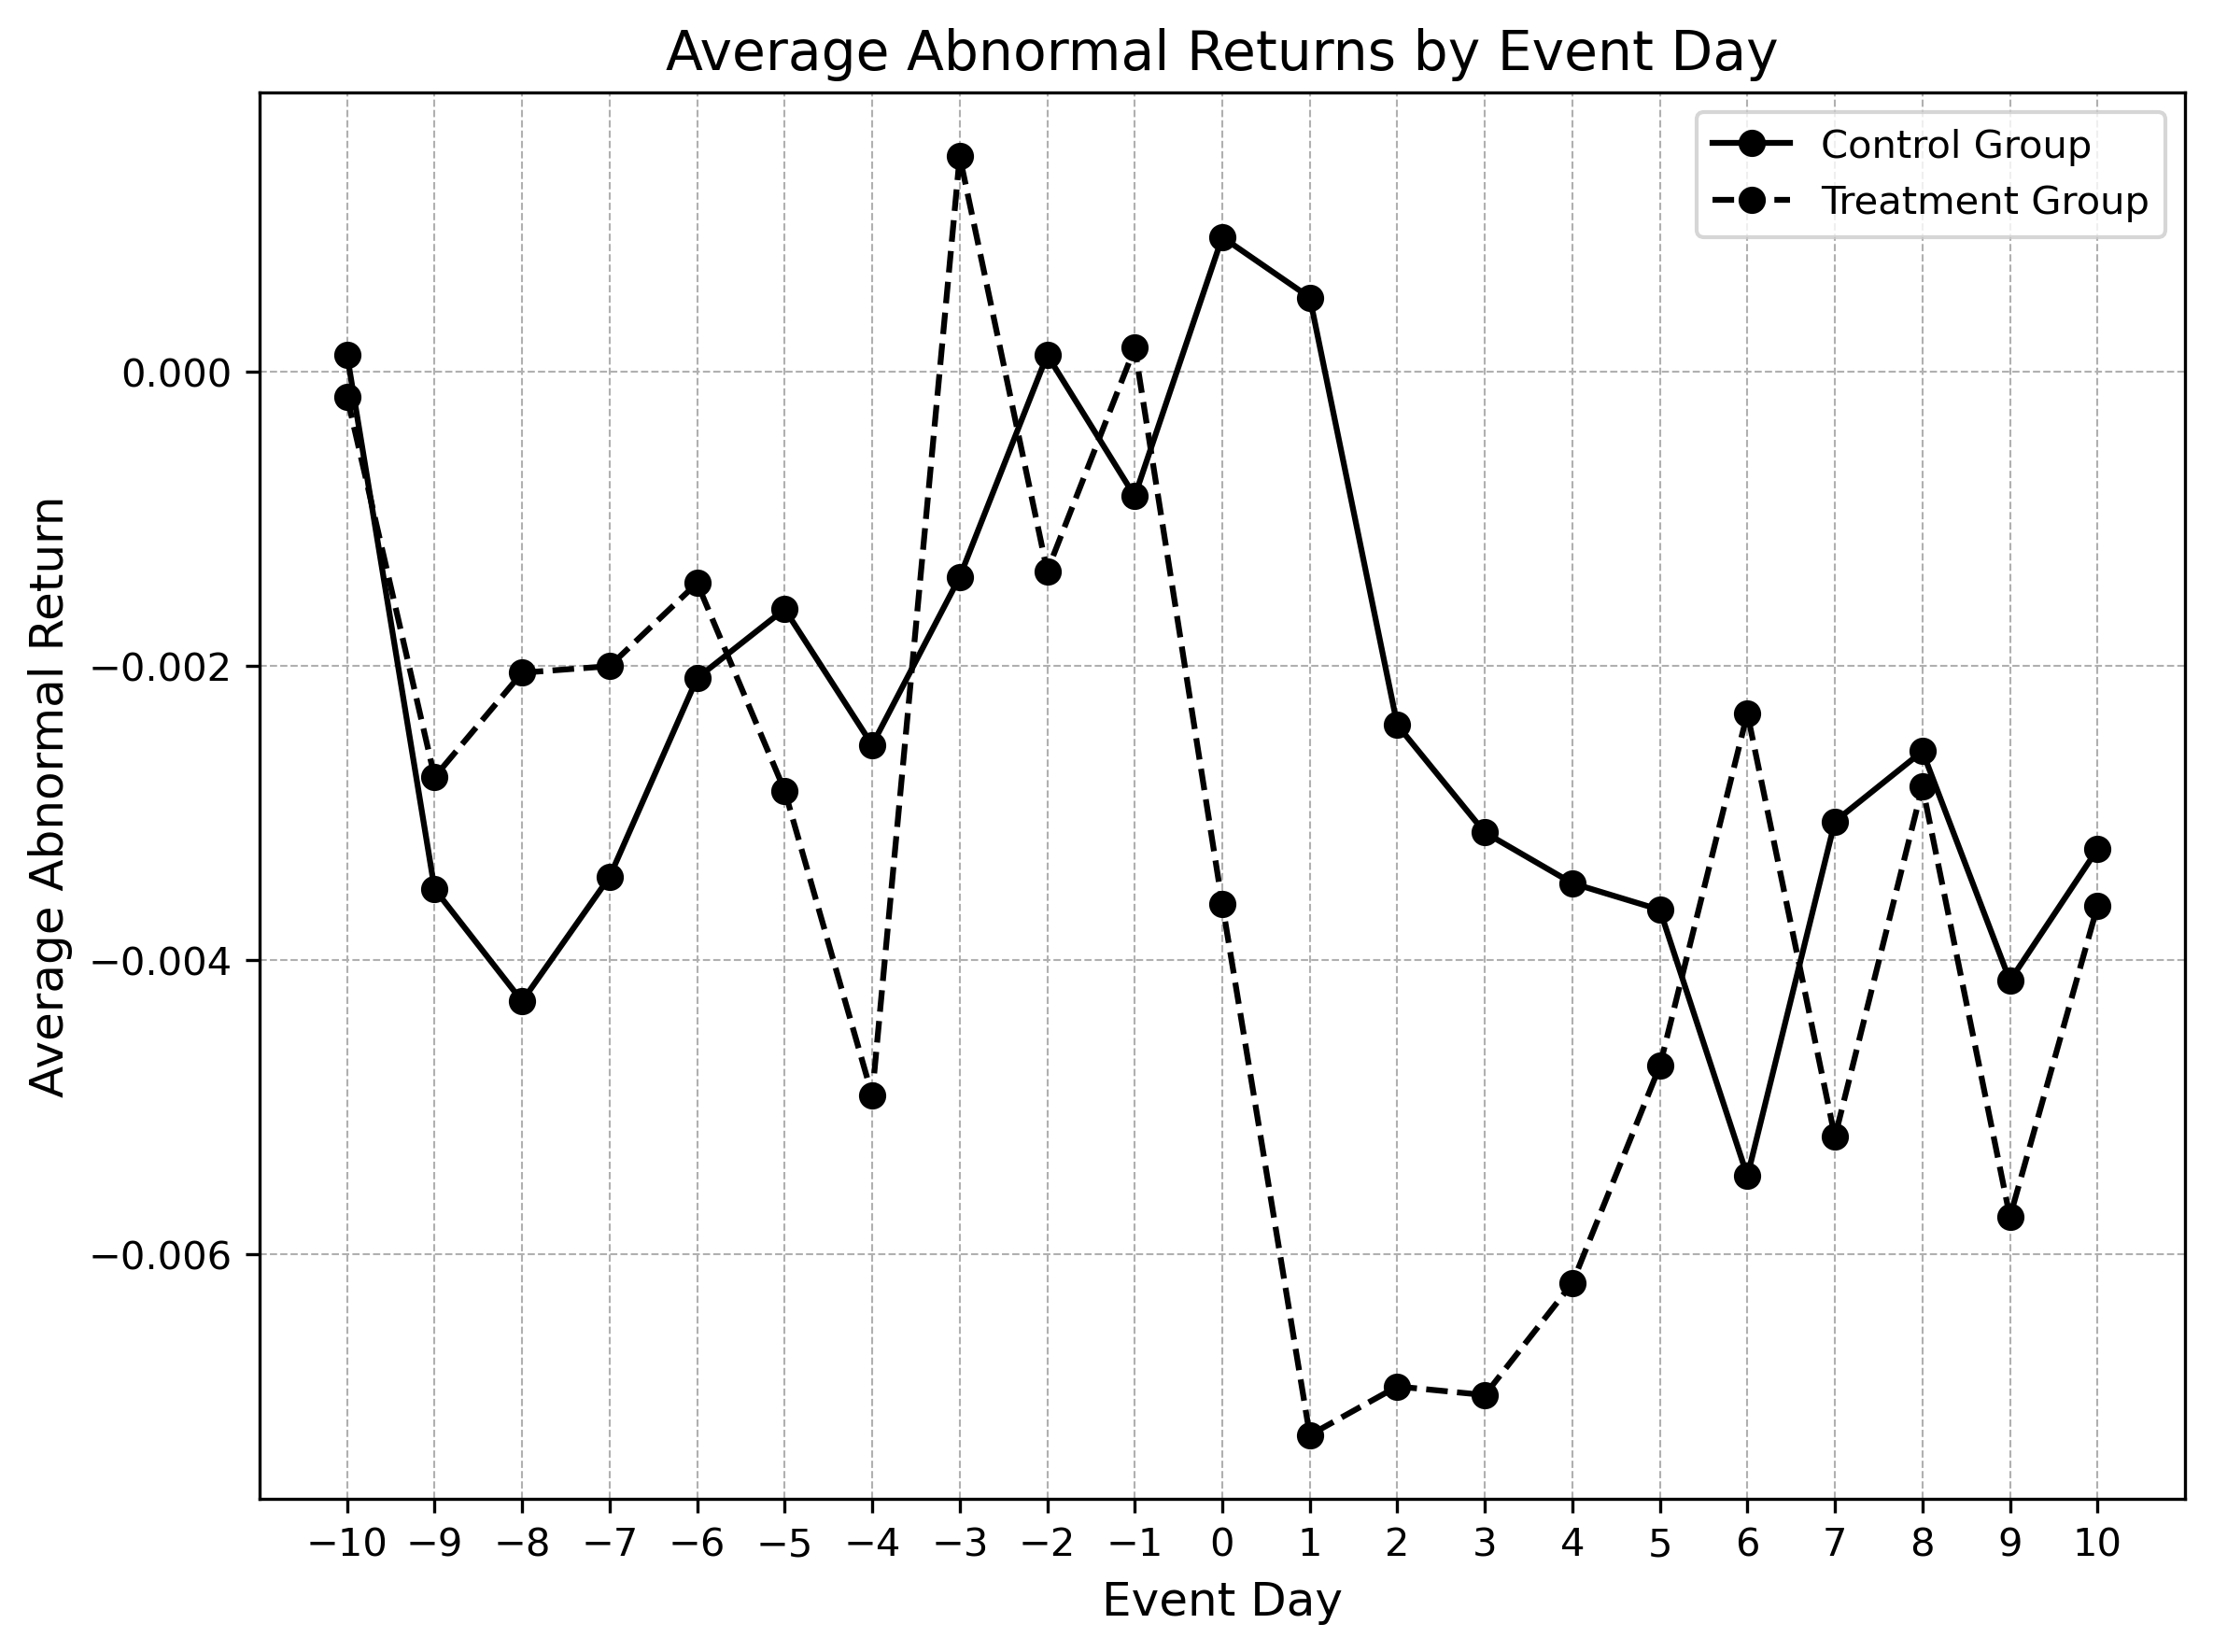

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 定义一个函数排除异常值（例如：超过均值 ± 2 标准差的值）
def remove_outliers(series, threshold=2):
    m = series.mean()
    std = series.std()
    filtered = series[(series >= m - threshold * std) & (series <= m + threshold * std)]
    return filtered

# 假设 df 为你的 DataFrame，其中包含以下列：
# AR_-10, AR_-9, …, AR_-1, AR_0, AR_1, …, AR_10，以及 truth（0: Control, 1: Treatment）

# 1. 提取所有事件窗异常收益的列（列名均以 "AR_" 开头）
ar_cols = [col for col in df.columns if col.startswith('AR_')]

# 2. 提取事件日（例如 -10, -9, …, 0, 1, …），并按升序排序
time_points = [int(col.replace('AR_', '')) for col in ar_cols]
time_points, ar_cols = zip(*sorted(zip(time_points, ar_cols)))
time_points = np.array(time_points)

# 3. 按 truth 分组计算每个事件日的平均异常收益（初步计算，不做异常值排除）
group_means = df.groupby('truth')[list(ar_cols)].mean().T
group_means.index = time_points

# 4. 对事件日 -4 到 -1 的数据进行异常值排除后重新计算均值
outlier_days = np.arange(-4, 0)  # 包括 -4, -3, -2, -1
for day in outlier_days:
    col_name = f'AR_{day}'
    for group in [0, 1]:
        # 提取当前组在该事件日的所有异常收益数据
        series = df[df['truth'] == group][col_name]
        # 排除异常值（例如，超过均值 ± 2 标准差的值）
        filtered_series = remove_outliers(series, threshold=2)
        # 用排除异常值后的均值替换原均值
        group_means.loc[day, group] = filtered_series.mean()

# 5. 绘制排除异常值后的折线图
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(time_points, group_means[0], marker='o', linestyle='-', color='black', label='Control Group')
plt.plot(time_points, group_means[1], marker='o', linestyle='--', color='black', label='Treatment Group')

plt.xlabel('Event Day', fontsize=12)
plt.ylabel('Average Abnormal Return', fontsize=12)
plt.title('Average Abnormal Returns by Event Day', fontsize=14)
plt.xticks(time_points)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# 保存高分辨率图片
plt.savefig('Average_Abnormal_Returns_Outlier_Removed.png', dpi=300)
plt.show()

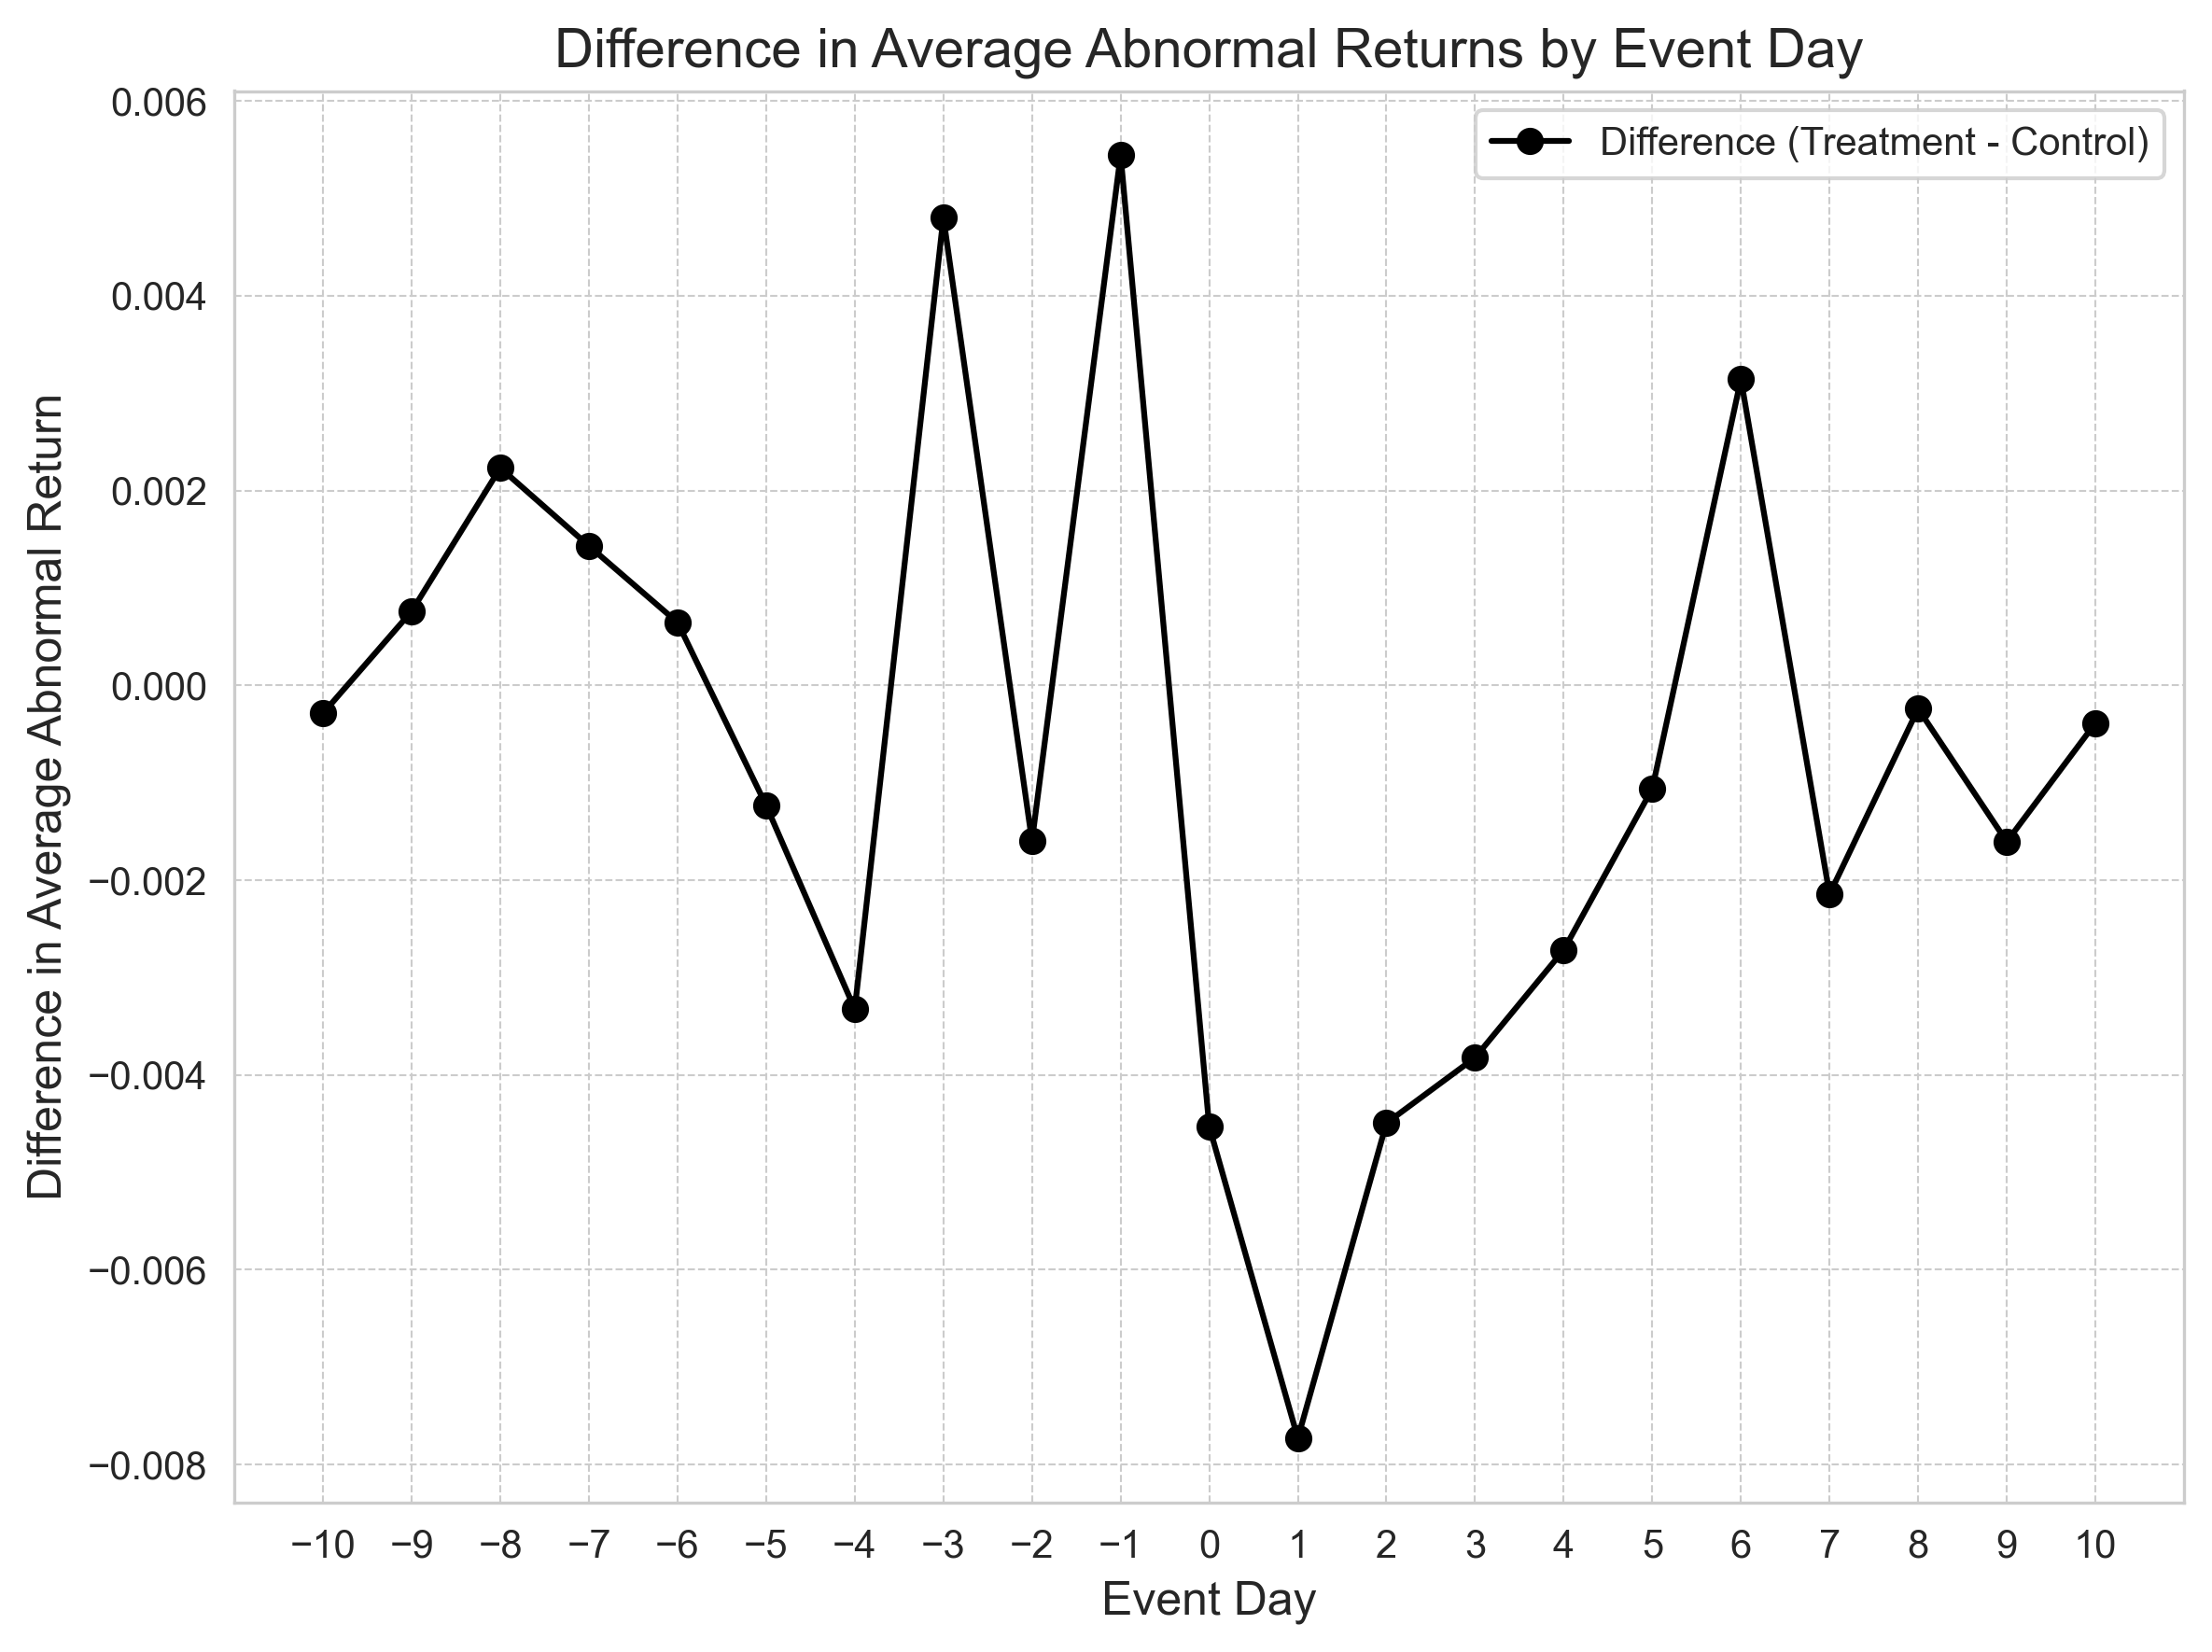

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 为你的 DataFrame，其中包含以下列：
# AR_-10, AR_-9, ..., AR_-1, AR_0, AR_1, ..., AR_10，以及 truth（0 表示对照组，1 表示处理组）

# 1. 提取所有事件窗异常收益的列（列名均以 "AR_" 开头）
ar_cols = [col for col in df.columns if col.startswith('AR_')]

# 2. 提取事件日（例如 -10, -9, ..., 0, 1, ...），并按升序排序
time_points = [int(col.replace('AR_', '')) for col in ar_cols]
time_points, ar_cols = zip(*sorted(zip(time_points, ar_cols)))

# 3. 按 truth 分组计算每个事件日的平均异常收益
#    group_means 的行索引为事件日，对应列为 truth 组（0: Control, 1: Treatment）
group_means = df.groupby('truth')[list(ar_cols)].mean().T

# 4. 计算两组之间的差值：Treatment - Control
difference = group_means[1] - group_means[0]

# 5. 绘制差值折线图，使用黑色线条，高清晰度（dpi=300），英文图注，符合学术规范
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(time_points, difference, marker='o', linestyle='-', color='black',
         label='Difference (Treatment - Control)')

plt.xlabel('Event Day', fontsize=12)
plt.ylabel('Difference in Average Abnormal Return', fontsize=12)
plt.title('Difference in Average Abnormal Returns by Event Day', fontsize=14)
plt.xticks(time_points)       # 横坐标显示正确的整数事件日
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# 6. 保存图片为高分辨率 PNG 文件（便于下载和学术使用）
plt.savefig('Difference_Average_Abnormal_Returns.png', dpi=300)
plt.show()


## 研究交易日不同于新闻发布日是否会影响到收益率

In [19]:
import pandas as pd
import statsmodels.formula.api as smf

# 1. 读取数据（请将 'your_data.csv' 替换为你的数据文件路径）
df = pd.read_excel('data_for_did_without_sential.xlsx')

# 2. 构造“不一致”变量：当“交易日0”与“event date”不一致时，mismatch=1，否则为0
df['mismatch'] = (df['交易日0'] != df['event date']).astype(int)

# 3. 计算事件窗 (-1, 1) 的累计异常收益 CAR = AR_-1 + AR_0 + AR_1
df['CAR'] = df['AR_-1'] + df['AR_0'] + df['AR_1']

# 4. 重命名带特殊字符的变量
rename_dict = {
    '年报资产报酬率（%）': 'AssetReturn',
    '年报资产报酬率TTM（%）': 'AssetReturn_TTM',
    '年报营业利润率（%）': 'OperatingProfitMargin',
    '流动比率（%）': 'CurrentRatio',
    '速动比率（%）': 'QuickRatio',
    '净资产负债率（%）': 'NetDebtRatio',
    '年报总资产周转率（次）': 'AssetTurnover',
    '年报总资产周转率TTM（次）': 'AssetTurnover_TTM',
    '资产负债率（%）': 'DebtRatio',
    '年报非流动资产/总资产（%）': 'NonCurrentAsset_Ratio'
}
df.rename(columns=rename_dict, inplace=True)

# 5. 定义其他控制变量（根据实际情况选择需要控制的变量）
control_vars = [
    'AssetReturn', 'AssetReturn_TTM', 'OperatingProfitMargin',
    'CurrentRatio', 'QuickRatio', 'NetDebtRatio',
    'AssetTurnover', 'AssetTurnover_TTM', 'DebtRatio',
    'NonCurrentAsset_Ratio'
]

# 6. 构造回归公式
formula = 'CAR ~ mismatch'
if control_vars:
    formula += ' + ' + ' + '.join(control_vars)

print("回归公式：", formula)

# 7. 使用 OLS 建模
model = smf.ols(formula, data=df).fit()
print(model.summary())


回归公式： CAR ~ mismatch + AssetReturn + AssetReturn_TTM + OperatingProfitMargin + CurrentRatio + QuickRatio + NetDebtRatio + AssetTurnover + AssetTurnover_TTM + DebtRatio + NonCurrentAsset_Ratio
                            OLS Regression Results                            
Dep. Variable:                    CAR   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.765
Date:                Sat, 15 Feb 2025   Prob (F-statistic):             0.0559
Time:                        10:30:50   Log-Likelihood:                 850.82
No. Observations:                 930   AIC:                            -1678.
Df Residuals:                     918   BIC:                            -1620.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  